In [37]:
import numpy as np
import experimental_methods as sim
import matplotlib.pyplot as plt
import pandas as pd
from mpl_toolkits import mplot3d
%matplotlib notebook

In [6]:
mu = 0.5; sigma = 1
R = (100, -100)
c = (1, 1)

In [41]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
# Define simulation parameters:
N = 200
# epsilon = 0.5; q = 0.8


# Create time step vector:
t = np.arange(N, 0, -1)

# Simulate realization of reward-maximization strategy:
block = sim.RewardMax(N, mu, sigma, epsilon, q, R, c)
block.experiment_sim()

# Plot reward-maximizing thresholds:
fig, ax = plt.subplots()
ax.plot(t, block.thresh, color='black', label='Decision Thresholds')
ax.plot(t, -block.thresh, color='black')
ax.set_xlim((N, 1))
ax.legend()

# Plot belief realization over thresholds:
fig, ax = plt.subplots()
ax.plot(t, block.belief, linewidth=5)
ax.plot(t, block.thresh, 'k', linewidth=5)
ax.plot(t, -block.thresh, 'k', linewidth=5)
ax.set_xlim((N, 0.8))
# ax.set_xticks(np.linspace(N, 1, 4), labels=[])
# ax.set_ylim(np.max(np.abs(ax.get_ylim()))*np.array([-1, 1]))
# ax.set_yticks(np.linspace(ax.get_ylim()[0], ax.get_ylim()[1], 5), labels=[])
# print(ax.get_yticks())
# ax.spines[['top', 'right']].set_visible(False)

RT_rewarded = block.RT[block.reward == R[0]]
RT_punished = block.RT[block.reward == R[1]]
choice_rewarded = block.choice[block.reward == R[0]]
choice_punished = block.choice[block.reward == R[1]]

# Plot action timeseries representation:
fig, ax = plt.subplots()
if len(RT_rewarded) > 0:
    S = ax.stem(RT_rewarded, choice_rewarded, markerfmt='go', linefmt='green')
    S[0].set_markersize(10); S[1].set_linewidth(5)

if len(RT_punished) > 0:
    S = ax.stem(RT_punished, choice_punished, markerfmt='ro', linefmt='red')
    S[0].set_markersize(10); S[1].set_linewidth(5)
    
ax.plot(t, np.zeros_like(t), color='black')
ax.set_xlim((N, 0.8))
# ax.set_xticks(np.linspace(N, 1, 4), labels=[])
# ax.set_yticks([])
# ax.spines[['top', 'right', 'left']].set_visible(False)


NameError: name 'epsilon' is not defined

In [47]:
def run_simulation(N, epsilon, q):
    block = sim.RewardMax(N, mu, sigma, epsilon, q, R, c)
    block.experiment_sim()
    choicetime = block.RT
    time_lags = [choicetime[i-1] - choicetime[i] for i in range(1,len(choicetime))]
    dfTL = pd.DataFrame(time_lags, columns=['TL'])
    dfTL['counts'] = choicetime[0:len(choicetime)-1]
    lags = dfTL.groupby(dfTL['TL']).count()
    return np.array(time_lags), np.array(lags.index), np.array(lags.counts), dfTL.shape[0]

def compute_burstiness(lags_line):
    mean = np.mean(lags_line)
    std = np.std(lags_line)
    return (std - mean)/(std+mean)

def compute_mean(lags_line):
    return np.mean(lags_line)

def compute_std(lags_line):
    return np.std(lags_line)

def bursty_sim(L):
    q = []; eps = []; b_i = []; mu_i = []; std_i = []
    for fr in np.linspace(0.5,0.99,L):
        for haz in np.linspace(0.01,0.5,L):
            print(haz,fr)
            all_lags, lags, freq, N = run_simulation(385, haz, fr)
            q.append(fr); eps.append(haz)
            b_i.append(compute_burstiness(all_lags))
            mu_i.append(compute_mean(all_lags))
            std_i.append(compute_std(all_lags))
        
    q = np.array(q); q = q.reshape(-1,1)
    eps = np.array(eps); eps = eps.reshape(-1,1)
    b_i = np.array(b_i); b_i = b_i.reshape(-1,1)
    mu_i = np.array(mu_i); mu_i = mu_i.reshape(-1,1)
    std_i = np.array(std_i); std_i = std_i.reshape(-1,1)
    return q, eps, b_i, mu_i, std_i

def plot(q, eps, b_i):
    fig, ax = plt.subplots(figsize=(5,2.5),dpi=150)
    plt.subplots_adjust(wspace=0.4)
    plt.subplot(121)
    plt.scatter(q,b_i)
    plt.ylim([-1, 1]); plt.xlim([0.5, 1])
    plt.xlabel('$q$'); plt.ylabel('$B$')
#     q_mdl = LinearRegression(); q_mdl.fit(q,b_i)
#     plt.plot(q, q_mdl.predict(q), 'r')
    
    plt.subplot(122)
    plt.scatter(eps,b_i)
    plt.ylim([-1, 1]); plt.xlim([0, 0.5])
    plt.xlabel('$\epsilon$'); plt.yticks([])
#     eps_mdl = LinearRegression(); eps_mdl.fit(eps,b_i)
#     plt.plot(eps, eps_mdl.predict(eps), 'r')
    plt.show()

In [56]:
q, e, b, m, s = bursty_sim(40)

0.0 0.5
0.01282051282051282 0.5
0.02564102564102564 0.5
0.038461538461538464 0.5
0.05128205128205128 0.5
0.0641025641025641 0.5
0.07692307692307693 0.5
0.08974358974358974 0.5
0.10256410256410256 0.5
0.11538461538461538 0.5
0.1282051282051282 0.5
0.14102564102564102 0.5
0.15384615384615385 0.5
0.16666666666666666 0.5
0.1794871794871795 0.5
0.1923076923076923 0.5
0.20512820512820512 0.5
0.21794871794871795 0.5
0.23076923076923075 0.5
0.24358974358974358 0.5
0.2564102564102564 0.5
0.2692307692307692 0.5
0.28205128205128205 0.5
0.2948717948717949 0.5
0.3076923076923077 0.5
0.3205128205128205 0.5
0.3333333333333333 0.5
0.34615384615384615 0.5
0.358974358974359 0.5
0.3717948717948718 0.5
0.3846153846153846 0.5
0.3974358974358974 0.5
0.41025641025641024 0.5
0.4230769230769231 0.5
0.4358974358974359 0.5
0.4487179487179487 0.5
0.4615384615384615 0.5
0.47435897435897434 0.5
0.48717948717948717 0.5
0.5 0.5
0.0 0.5128205128205128
0.01282051282051282 0.5128205128205128
0.02564102564102564 0.512820

0.4230769230769231 0.5641025641025641
0.4358974358974359 0.5641025641025641
0.4487179487179487 0.5641025641025641
0.4615384615384615 0.5641025641025641
0.47435897435897434 0.5641025641025641
0.48717948717948717 0.5641025641025641
0.5 0.5641025641025641
0.0 0.5769230769230769
0.01282051282051282 0.5769230769230769
0.02564102564102564 0.5769230769230769
0.038461538461538464 0.5769230769230769
0.05128205128205128 0.5769230769230769
0.0641025641025641 0.5769230769230769
0.07692307692307693 0.5769230769230769
0.08974358974358974 0.5769230769230769
0.10256410256410256 0.5769230769230769
0.11538461538461538 0.5769230769230769
0.1282051282051282 0.5769230769230769
0.14102564102564102 0.5769230769230769
0.15384615384615385 0.5769230769230769
0.16666666666666666 0.5769230769230769
0.1794871794871795 0.5769230769230769
0.1923076923076923 0.5769230769230769
0.20512820512820512 0.5769230769230769
0.21794871794871795 0.5769230769230769
0.23076923076923075 0.5769230769230769
0.24358974358974358 0.576

0.14102564102564102 0.641025641025641
0.15384615384615385 0.641025641025641
0.16666666666666666 0.641025641025641
0.1794871794871795 0.641025641025641
0.1923076923076923 0.641025641025641
0.20512820512820512 0.641025641025641
0.21794871794871795 0.641025641025641
0.23076923076923075 0.641025641025641
0.24358974358974358 0.641025641025641
0.2564102564102564 0.641025641025641
0.2692307692307692 0.641025641025641
0.28205128205128205 0.641025641025641
0.2948717948717949 0.641025641025641
0.3076923076923077 0.641025641025641
0.3205128205128205 0.641025641025641
0.3333333333333333 0.641025641025641
0.34615384615384615 0.641025641025641
0.358974358974359 0.641025641025641
0.3717948717948718 0.641025641025641
0.3846153846153846 0.641025641025641
0.3974358974358974 0.641025641025641
0.41025641025641024 0.641025641025641
0.4230769230769231 0.641025641025641
0.4358974358974359 0.641025641025641
0.4487179487179487 0.641025641025641
0.4615384615384615 0.641025641025641
0.47435897435897434 0.6410256

0.3717948717948718 0.7051282051282051
0.3846153846153846 0.7051282051282051
0.3974358974358974 0.7051282051282051
0.41025641025641024 0.7051282051282051
0.4230769230769231 0.7051282051282051
0.4358974358974359 0.7051282051282051
0.4487179487179487 0.7051282051282051
0.4615384615384615 0.7051282051282051
0.47435897435897434 0.7051282051282051
0.48717948717948717 0.7051282051282051
0.5 0.7051282051282051
0.0 0.717948717948718
0.01282051282051282 0.717948717948718
0.02564102564102564 0.717948717948718
0.038461538461538464 0.717948717948718
0.05128205128205128 0.717948717948718
0.0641025641025641 0.717948717948718
0.07692307692307693 0.717948717948718
0.08974358974358974 0.717948717948718
0.10256410256410256 0.717948717948718
0.11538461538461538 0.717948717948718
0.1282051282051282 0.717948717948718
0.14102564102564102 0.717948717948718
0.15384615384615385 0.717948717948718
0.16666666666666666 0.717948717948718
0.1794871794871795 0.717948717948718
0.1923076923076923 0.717948717948718
0.205

0.10256410256410256 0.782051282051282
0.11538461538461538 0.782051282051282
0.1282051282051282 0.782051282051282
0.14102564102564102 0.782051282051282
0.15384615384615385 0.782051282051282
0.16666666666666666 0.782051282051282
0.1794871794871795 0.782051282051282
0.1923076923076923 0.782051282051282
0.20512820512820512 0.782051282051282
0.21794871794871795 0.782051282051282
0.23076923076923075 0.782051282051282
0.24358974358974358 0.782051282051282
0.2564102564102564 0.782051282051282
0.2692307692307692 0.782051282051282
0.28205128205128205 0.782051282051282
0.2948717948717949 0.782051282051282
0.3076923076923077 0.782051282051282
0.3205128205128205 0.782051282051282
0.3333333333333333 0.782051282051282
0.34615384615384615 0.782051282051282
0.358974358974359 0.782051282051282
0.3717948717948718 0.782051282051282
0.3846153846153846 0.782051282051282
0.3974358974358974 0.782051282051282
0.41025641025641024 0.782051282051282
0.4230769230769231 0.782051282051282
0.4358974358974359 0.782051

0.3333333333333333 0.8461538461538461
0.34615384615384615 0.8461538461538461
0.358974358974359 0.8461538461538461
0.3717948717948718 0.8461538461538461
0.3846153846153846 0.8461538461538461
0.3974358974358974 0.8461538461538461
0.41025641025641024 0.8461538461538461
0.4230769230769231 0.8461538461538461
0.4358974358974359 0.8461538461538461
0.4487179487179487 0.8461538461538461
0.4615384615384615 0.8461538461538461
0.47435897435897434 0.8461538461538461
0.48717948717948717 0.8461538461538461
0.5 0.8461538461538461
0.0 0.858974358974359
0.01282051282051282 0.858974358974359
0.02564102564102564 0.858974358974359
0.038461538461538464 0.858974358974359
0.05128205128205128 0.858974358974359
0.0641025641025641 0.858974358974359
0.07692307692307693 0.858974358974359
0.08974358974358974 0.858974358974359
0.10256410256410256 0.858974358974359
0.11538461538461538 0.858974358974359
0.1282051282051282 0.858974358974359
0.14102564102564102 0.858974358974359
0.15384615384615385 0.858974358974359
0.1

0.0641025641025641 0.9230769230769231
0.07692307692307693 0.9230769230769231
0.08974358974358974 0.9230769230769231
0.10256410256410256 0.9230769230769231
0.11538461538461538 0.9230769230769231
0.1282051282051282 0.9230769230769231
0.14102564102564102 0.9230769230769231
0.15384615384615385 0.9230769230769231
0.16666666666666666 0.9230769230769231
0.1794871794871795 0.9230769230769231
0.1923076923076923 0.9230769230769231
0.20512820512820512 0.9230769230769231
0.21794871794871795 0.9230769230769231
0.23076923076923075 0.9230769230769231
0.24358974358974358 0.9230769230769231
0.2564102564102564 0.9230769230769231
0.2692307692307692 0.9230769230769231
0.28205128205128205 0.9230769230769231
0.2948717948717949 0.9230769230769231
0.3076923076923077 0.9230769230769231
0.3205128205128205 0.9230769230769231
0.3333333333333333 0.9230769230769231
0.34615384615384615 0.9230769230769231
0.358974358974359 0.9230769230769231
0.3717948717948718 0.9230769230769231
0.3846153846153846 0.9230769230769231


0.28205128205128205 0.9871794871794872
0.2948717948717949 0.9871794871794872
0.3076923076923077 0.9871794871794872
0.3205128205128205 0.9871794871794872
0.3333333333333333 0.9871794871794872
0.34615384615384615 0.9871794871794872
0.358974358974359 0.9871794871794872
0.3717948717948718 0.9871794871794872
0.3846153846153846 0.9871794871794872
0.3974358974358974 0.9871794871794872
0.41025641025641024 0.9871794871794872
0.4230769230769231 0.9871794871794872
0.4358974358974359 0.9871794871794872
0.4487179487179487 0.9871794871794872
0.4615384615384615 0.9871794871794872
0.47435897435897434 0.9871794871794872
0.48717948717948717 0.9871794871794872
0.5 0.9871794871794872
0.0 1.0
0.01282051282051282 1.0
0.02564102564102564 1.0
0.038461538461538464 1.0
0.05128205128205128 1.0
0.0641025641025641 1.0
0.07692307692307693 1.0
0.08974358974358974 1.0
0.10256410256410256 1.0
0.11538461538461538 1.0
0.1282051282051282 1.0
0.14102564102564102 1.0
0.15384615384615385 1.0
0.16666666666666666 1.0
0.179487

<IPython.core.display.Javascript object>


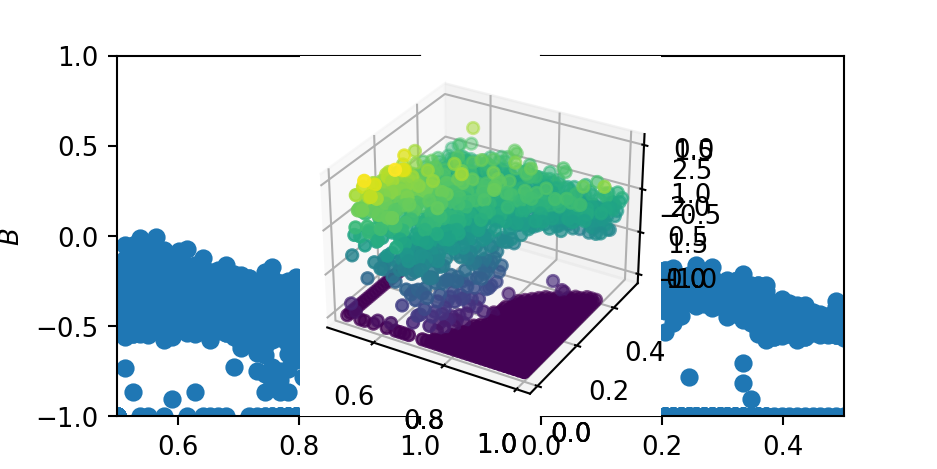

In [57]:
plot(q, e, b)

<IPython.core.display.Javascript object>


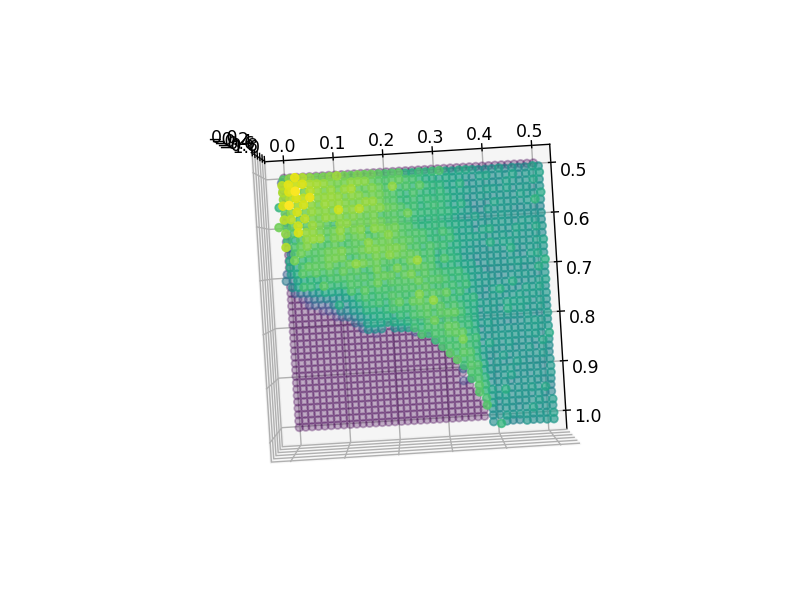

In [66]:
ax = plt.axes(projection='3d')

# Data for a three-dimensional line
ax.scatter3D(q,e,b, c=b)

<IPython.core.display.Javascript object>


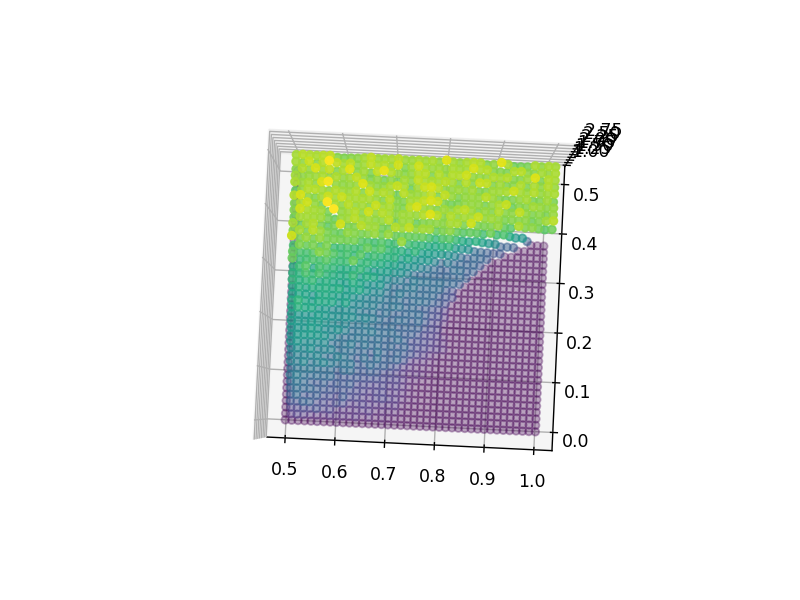

In [67]:
ax = plt.axes(projection='3d')

# Data for a three-dimensional line
ax.scatter3D(q,e,m, c=m)

<IPython.core.display.Javascript object>


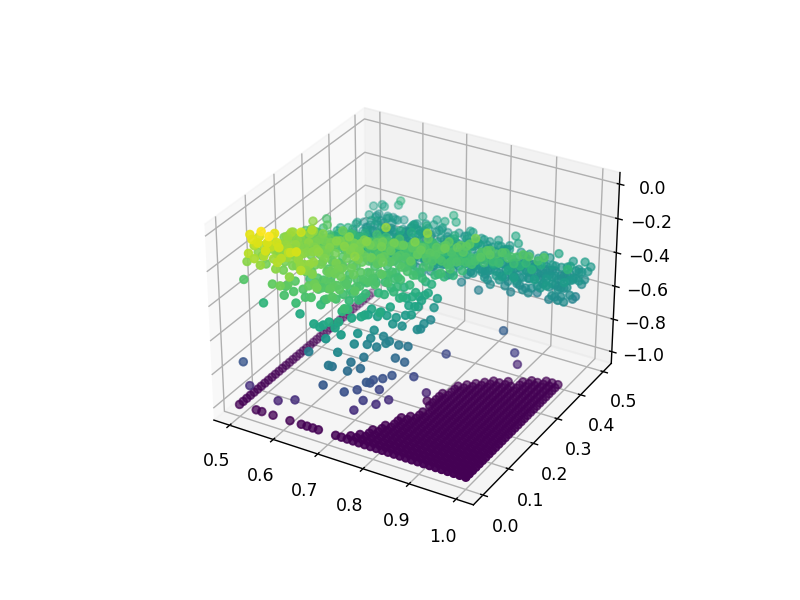

In [64]:
ax = plt.axes(projection='3d')

# Data for a three-dimensional line
ax.scatter3D(q,e,s, c=s)